In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from argparse import ArgumentParser
from sklearn.utils import shuffle
from skimage.io import imread
import PIL

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as T
from torchvision import models

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# from torchsampler import ImbalancedDatasetSampler
# from torchmetrics.functional import auroc, precision, recall, f1_score, precision_recall_curve
import albumentations as albu
import albumentations.pytorch
import matplotlib.pyplot as plt
import torchmetrics
import timm
import random

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu


In [3]:
data_dir = '/kaggle/input/full-fullsize/'

image_size = (224, 224)     # image input size (depends on data pre-processing)
val_percent = 0.1           # how much of total training samples are used for model selection (default 10%)
batch_size = 10             # batch size may need to be adjusted depending on GPU memory
num_workers = 3             # number threads for data processing

### Preprocess data

In [4]:
preprocess_transform = albu.Compose([
                                     albu.Resize(image_size[0], image_size[0], p=1),
                                     albu.Normalize(),
                                     albu.pytorch.ToTensorV2(),
                                    ])

In [5]:
def preprocess_df(data_dir=data_dir):
    df = pd.read_csv(os.path.join(data_dir,'breast-level_annotations.csv'))
    df['malignancy_label'] = df['breast_birads']

    # Define positive and negatives based on BI-RADS categories
    df.loc[df['malignancy_label'] == 'BI-RADS 1', 'malignancy_label'] = 0
    df.loc[df['malignancy_label'] == 'BI-RADS 2', 'malignancy_label'] = 0
    df.loc[df['malignancy_label'] == 'BI-RADS 3', 'malignancy_label'] = 1
    df.loc[df['malignancy_label'] == 'BI-RADS 4', 'malignancy_label'] = 1
    df.loc[df['malignancy_label'] == 'BI-RADS 5', 'malignancy_label'] = 1

    # Use pre-defined splits to separate data into development and testing
    train_df = df[df['split'] == 'training'].head(100) #####################################
    test_df = df[df['split'] == 'test'].head(50) ###########################################
    
    return train_df, test_df

In [6]:
class Dataset(Dataset):
    def __init__(self, df, data_dir, augmentation=preprocess_transform):
        self.df = df
        self.data_dir = data_dir
        self.do_augment = augmentation
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.data_dir, 'png/png', row['study_id'], row['image_id'] + '.png')
        img_label = np.array(row['malignancy_label'], dtype='int64')
        
        image = PIL.Image.open(img_path)
        transformed = self.do_augment(image=np.array(image.convert('RGB')))
        tensor = transformed["image"]    
    
        return tensor

In [7]:
def show_image_pair(image1, image2):
    fig = plt.figure(figsize=(10, 20))
    fig.add_subplot(1,2,1)
    plt.imshow(image1)
    fig.add_subplot(1,2, 2)
    plt.imshow(image2)
    plt.show()

def test_dataset(df, idx=0):
    dataset = Dataset(df, data_dir)
    
    img_path = os.path.join(data_dir, 'png/png', dataset.df.iloc[idx]['study_id'], dataset.df.iloc[idx]['image_id'] + '.png')
    image1 = PIL.Image.open(img_path).convert('RGB')

    tensor = dataset[idx].squeeze()
    image2 = torchvision.transforms.ToPILImage()(tensor)

    show_image_pair(image1, image2)

In [8]:
train_df, test_df = preprocess_df()
train_df

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split,malignancy_label
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training,0
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training,0
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training,0
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training,0
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training,0
...,...,...,...,...,...,...,...,...,...,...,...
127,efedb7b0555ccfcf576d26ada43c20bc,670179435017d45a008b8cb3f2145661,563da91801fb12a15b4f9e1bb96fb19f,R,MLO,3518,2800,BI-RADS 1,DENSITY C,training,0
128,d010dbb93a1a164ce8afc0b62d22de98,da99ff6022955ce6149d7b515995105d,2530e73814b6a250140fab195ac789cc,L,CC,3518,2800,BI-RADS 4,DENSITY C,training,1
129,d010dbb93a1a164ce8afc0b62d22de98,da99ff6022955ce6149d7b515995105d,73d20cbf87ec2637a3de9d950ad809b2,L,MLO,3518,2800,BI-RADS 4,DENSITY C,training,1
130,d010dbb93a1a164ce8afc0b62d22de98,da99ff6022955ce6149d7b515995105d,155ebfbe2a79b191c1a9b85177c11a94,R,CC,3518,2800,BI-RADS 1,DENSITY C,training,0


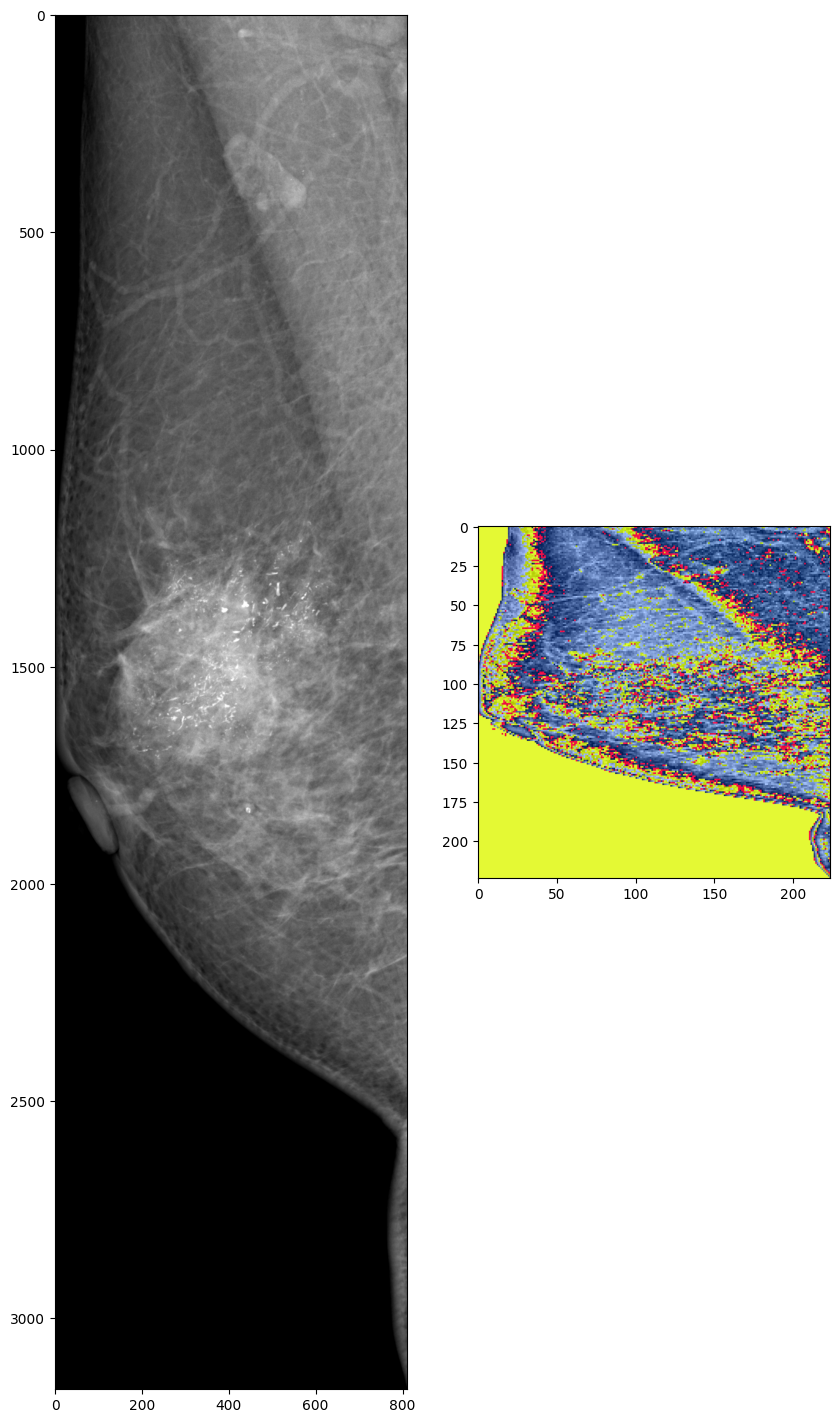

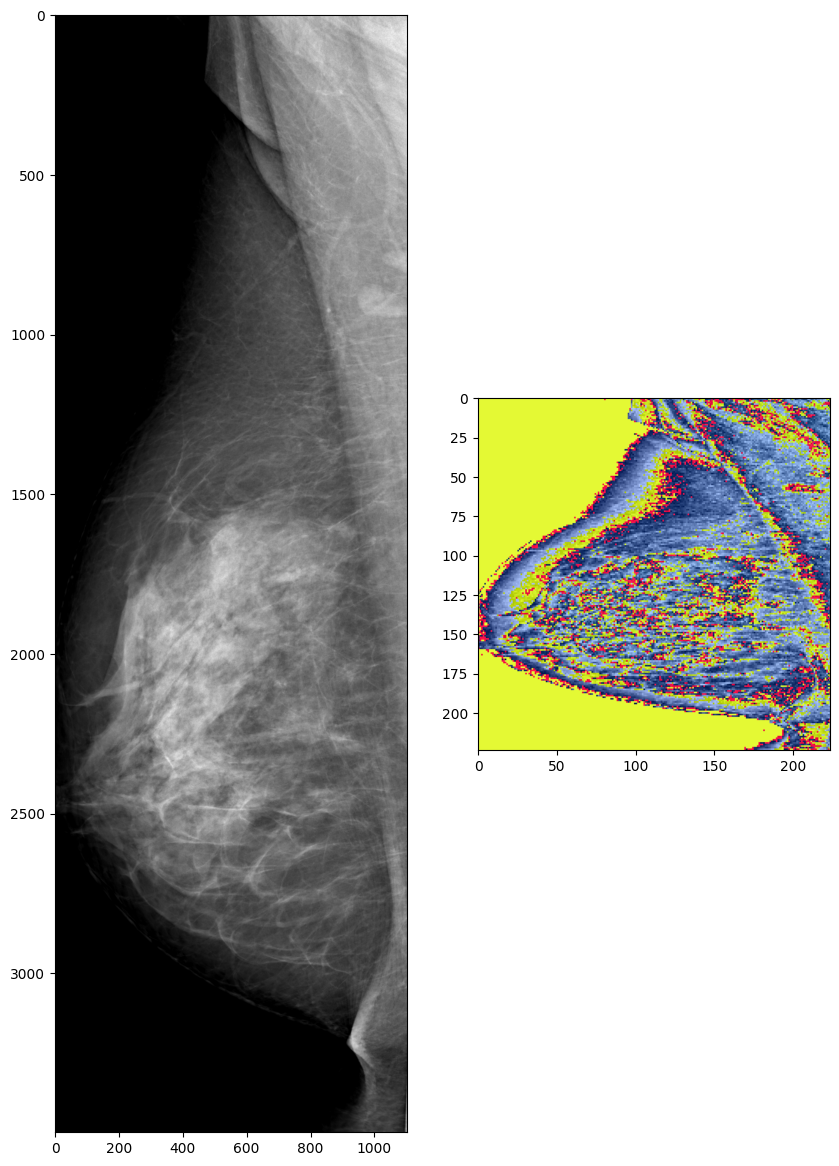

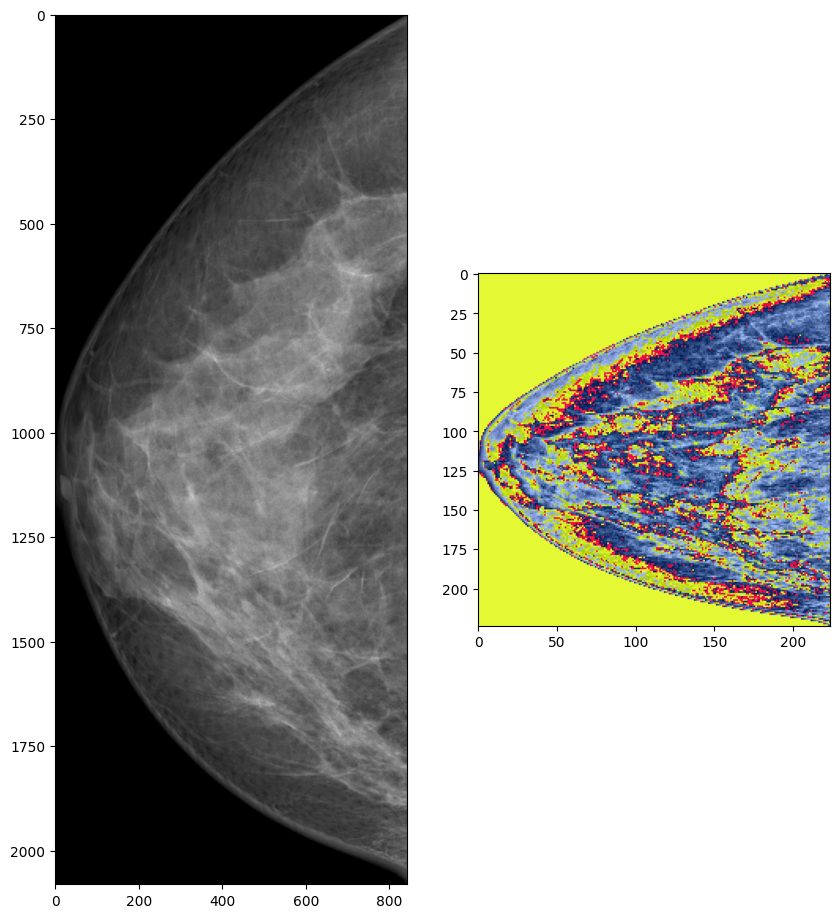

In [9]:
for idx in [random.choice(range(100)) for i in range(3)]:
    test_dataset(train_df, idx)

### Extract feature

In [10]:
model_name = 'densenet121'
layer_name = 'features'

get_model = getattr(torchvision.models, model_name)

def extract_features(df, data_dir, batch_size, num_workers):

    model = get_model(weights=models.DenseNet121_Weights.DEFAULT)
    model = model.to(device)
    model.eval()

    # register hook to access to features in forward pass
    features = []
    
    def hook(module, input, output):
        N,C,H,W = output.shape
        output = output.reshape(N,C,-1)
        features.append(output.mean(dim=2).cpu().detach().numpy())
        
    handle = model._modules.get(layer_name).register_forward_hook(hook)

    dataset = Dataset(df, data_dir)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    for i_batch, inputs in tqdm(enumerate(loader), total=len(loader)):
        _ = model(inputs.to(device))

    features = np.concatenate(features)

    features = pd.DataFrame(features)
    features = features.add_prefix('feature_')
    features.loc[:,'label'] = df['malignancy_label']
    
    handle.remove()
    del model

    return features

In [11]:
features_train = extract_features(train_df, 
                                  data_dir, 
                                  batch_size, 
                                  num_workers)

features_test = extract_features(test_df, 
                                 data_dir, 
                                 batch_size, 
                                 num_workers)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 88.8MB/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 10/10 [00:12<00:00,  1.13it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 10/10 [00:12<00:00,  1.28s/it]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

In [12]:
features_train

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023,label
0,0.000024,0.005288,0.000327,0.003197,-0.021996,-0.055347,0.001321,0.001107,0.435891,0.000095,...,0.471952,0.250515,1.715997,1.830523,0.529159,-1.423385,-2.849732,2.259650,-0.471919,0
1,-0.000035,-0.001679,0.003780,0.002731,-0.077061,-0.368080,0.000602,0.004438,0.432744,0.000457,...,0.969368,-0.170640,1.910818,1.143508,0.398739,-1.151310,-0.662387,0.723047,-0.277414,0
2,0.000054,0.001635,0.001762,0.004434,-0.051056,-0.114688,0.001043,0.002414,0.377139,0.000116,...,0.048545,0.036062,1.569874,2.010384,1.747563,-1.272434,-1.696274,1.787210,-0.361208,0
3,0.000001,0.000058,0.004037,0.003054,-0.061853,-0.141721,0.001029,0.004316,0.363181,0.000330,...,0.523357,-0.249118,1.788089,2.438593,1.397807,-1.347516,-1.865689,1.821996,-0.107066,0
4,-0.000047,0.004579,0.001459,0.003078,-0.037404,-0.168427,0.001076,0.001901,0.345531,0.000349,...,0.837766,-0.118357,0.961220,1.011081,0.286380,-0.761926,-2.532651,1.278715,-0.130205,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.000076,0.003462,0.005332,0.003855,-0.077026,-0.155193,0.000162,0.005601,0.217096,0.000099,...,-0.756558,-0.207194,2.811874,0.061369,-0.622873,-0.875987,0.316036,-0.022412,-0.792047,0
96,-0.000033,0.004472,-0.000172,0.003455,-0.073965,-0.065107,0.000533,0.003091,0.373968,-0.000086,...,0.410973,0.175307,2.333455,1.087239,-0.375294,-0.761474,-2.617269,1.482139,0.234034,1
97,-0.000005,0.003049,0.003949,0.003683,-0.118231,-0.341843,-0.000097,0.004301,0.183397,-0.000026,...,0.419621,-0.084491,3.766369,1.764585,-0.497478,-1.377199,-0.853200,1.511465,-0.423643,1
98,-0.000014,0.003294,0.001211,0.004091,-0.085367,0.033986,0.000676,0.004712,0.293870,0.000021,...,0.223722,0.049889,1.442140,0.669848,2.170752,-0.880788,-1.976146,2.842361,-0.068640,0


In [13]:
# Check NaN
print(features_train.isna().any().any())
print(features_test.isna().any().any())

True
True


### Machine Learning Model

In [ ]:
!pip install scikit-fuzzy

In [14]:
import skfuzzy as fuzz
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

In [15]:
X_train = features_train.drop('label', axis=1)  # Features
y_train = features_train['label']
X_test = features_test.drop('label', axis=1)  # Features
y_test = features_test['label']

In [ ]:
# model = RandomForestClassifier()
# model.fit(X_train, y_train)

In [ ]:
mi_selector = SelectKBest(mutual_info_classif, k=500)

# Transform the data
X_selected = mi_selector.fit_transform(X_train, y_train)

In [ ]:
# Perform Fuzzy C-Means clustering using skfuzzy
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X_selected.T, c=2,
                                                 m=2.5, error=0.005, maxiter=1000)

# Evaluate the quality of the clustering
intra_cluster_variance = np.sum(np.multiply(u.T, d.T) ** 2)
print(intra_cluster_variance)

In [ ]:
# Transform the data
X_test_selected = mi_selector.fit_transform(concatenated_test_features, y_test)
# Predict using the test set
u_test, _, _, _, _, _ = fuzz.cluster.cmeans_predict(X_test_selected.T, cntr, m=2, error=0.005, maxiter=1000)
print(u_test)

# Get the most likely class for each sample
y_pred = np.argmax(u_test, axis=0)
print(y_pred)